<a href="https://colab.research.google.com/github/Aamna-Khan-Git/Models/blob/main/Fish_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import (
    ResNet50, MobileNetV2, InceptionV3, EfficientNetB0,
    VGG16, DenseNet121, Xception )
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = r'/content/drive/MyDrive/data/train'
test_data = r'/content/drive/MyDrive/data/test'
val_data = r'/content/drive/MyDrive/data/val'

In [ ]:
from PIL import Image

def load_and_normalize_images(val_data, target_size=(224, 224)):
    """Loads images from a directory, normalizes pixel values, and returns images and labels."""
    images = []
    labels = []
    for label in os.listdir(val_data):
        label_dir = os.path.join(val_data, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, image_name)
                    try:
                        with Image.open(image_path) as img:
                            # Convert image to RGB if it's not (to handle grayscale etc.)
                            img = img.convert('RGB')
                            img_array = np.array(img)

                             # Resize image
                            img_resized = img.resize(target_size)

                            img_array = np.array(img_resized)

                            # Normalize pixel values to 0-1 scale
                            normalized_img_array = img_array / 255.0

                            images.append(normalized_img_array)
                            labels.append(label)
                    except Exception as e:
                        print(f"Could not load or process image {image_path}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
from PIL import Image

def load_and_normalize_images(test_data, target_size=(224, 224)):
    """Loads images from a directory, normalizes pixel values, and returns images and labels."""
    images = []
    labels = []
    for label in os.listdir(test_data):
        label_dir = os.path.join(test_data, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, image_name)
                    try:
                        with Image.open(image_path) as img:
                            # Convert image to RGB if it's not (to handle grayscale etc.)
                            img = img.convert('RGB')
                            img_array = np.array(img)

                             # Resize image
                            img_resized = img.resize(target_size)

                            img_array = np.array(img_resized)

                            # Normalize pixel values to 0-1 scale
                            normalized_img_array = img_array / 255.0

                            images.append(normalized_img_array)
                            labels.append(label)
                    except Exception as e:
                        print(f"Could not load or process image {image_path}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
from PIL import Image

def load_and_normalize_images(val_data, target_size=(224, 224)):
    """Loads images from a directory, normalizes pixel values, and returns images and labels."""
    images = []
    labels = []
    for label in os.listdir(test_data):
        label_dir = os.path.join(test_data, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, image_name)
                    try:
                        with Image.open(image_path) as img:
                            # Convert image to RGB if it's not (to handle grayscale etc.)
                            img = img.convert('RGB')
                            img_array = np.array(img)

                             # Resize image
                            img_resized = img.resize(target_size)

                            img_array = np.array(img_resized)

                            # Normalize pixel values to 0-1 scale
                            normalized_img_array = img_array / 255.0

                            images.append(normalized_img_array)
                            labels.append(label)
                    except Exception as e:
                        print(f"Could not load or process image {image_path}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
#!pip uninstall -y imgaug numpy
#!pip install numpy==1.26.4 imgaug tqdm opencv-python

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2;

In [ ]:
import os
import cv2
import numpy as np
from imgaug import augmenters as iaa
from tqdm import tqdm
import shutil

def create_augmenter():
    """Create an image augmentation sequence with moderate transformations"""
    seq = iaa.Sequential([
        # Geometric transformations
        iaa.Sometimes(0.5, iaa.Fliplr(0.5)),  # horizontal flips
        iaa.Sometimes(0.3, iaa.Flipud(0.3)),  # vertical flips
        iaa.Sometimes(0.4, iaa.Affine(
            rotate=(-15, 15),  # rotation
            shear=(-8, 8),     # shear
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}  # scaling
        )),

        # Color transformations
        iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 0.8))),
        iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(scale=(0, 0.03*255))),
        iaa.Sometimes(0.4, iaa.Multiply((0.9, 1.1))),  # brightness
        iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 0.3))),  # slight grayscale
    ], random_order=True)

    return seq

def augment_images_in_folder(input_folder, output_subfolder, augmenter, num_augmentations=3):
    """
    Augment all images in a folder while preserving originals
    :param input_folder: Path to folder with original images
    :param output_subfolder: Path to save augmented images
    :param augmenter: Augmentation sequence
    :param num_augmentations: Number of augmented versions to create per image
    """
    if not os.path.exists(output_subfolder):
        os.makedirs(output_subfolder)

    # Get all image files in the input folder
    image_files = [f for f in os.listdir(input_folder)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.webp'))]

    for image_file in tqdm(image_files, desc=f"Processing {os.path.basename(input_folder)}"):
        # Read the original image
        img_path = os.path.join(input_folder, image_file)
        image = cv2.imread(img_path)
        if image is None:
            continue

        # Save original image to output folder
        original_output_path = os.path.join(output_subfolder, image_file)

        # Only copy if not already present
        if not os.path.exists(original_output_path):
            shutil.copy2(img_path, original_output_path)

        # Create and save augmented versions
        for i in range(num_augmentations):
            augmented_image = augmenter.augment_image(image)
            base_name, ext = os.path.splitext(image_file)
            output_path = os.path.join(output_subfolder, f"{base_name}_aug{i}{ext}")
            cv2.imwrite(output_path, augmented_image)

def process_input_folder(input_folder, output_folder, num_augmentations=3):
    """
    Process all subfolders in the input folder
    :param input_folder: Root folder containing subfolders with images
    :param output_folder: Root folder to save augmented images
    :param num_augmentations: Number of augmented versions per image
    """
    augmenter = create_augmenter()

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get all subfolders (class directories)
    subfolders = [f.path for f in os.scandir(input_folder) if f.is_dir()]

    # If input_folder itself contains images, process them first
    if any(f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.webp')) for f in os.listdir(input_folder)):
        augment_images_in_folder(input_folder, output_folder, augmenter, num_augmentations)

    # Process each subfolder
    for folder in subfolders:
        folder_name = os.path.basename(folder)
        output_subfolder = os.path.join(output_folder, folder_name)

        print(f"\nProcessing folder: {folder_name}")
        augment_images_in_folder(folder, output_subfolder, augmenter, num_augmentations)

if __name__ == "__main__":
    # User-defined folders
    input_folder = "/content/drive/MyDrive/data/train"  # Replace with your input path
    output_folder = "/content/drive/MyDrive/data/augmented"  # Replace with your output path
    num_augmentations = 3  # Number of augmented versions per image

    # Verify input folder exists
    if not os.path.exists(input_folder):
        raise ValueError(f"Input folder {input_folder} does not exist!")

    print(f"\nStarting image augmentation:")
    print(f"Input directory: {input_folder}")
    print(f"Output directory: {output_folder}")
    print(f"Generating {num_augmentations} augmented versions per image")

    process_input_folder(input_folder, output_folder, num_augmentations)

    print("\nAugmentation complete!")
    print(f"Original images + {num_augmentations} augmented versions saved to: {output_folder}")


Starting image augmentation:
Input directory: /content/drive/MyDrive/data/train
Output directory: /content/drive/MyDrive/data/augmented
Generating 3 augmented versions per image

Processing folder: fish sea_food trout


Processing fish sea_food trout:   1%|          | 5/580 [00:20<38:54,  4.06s/it]


KeyboardInterrupt: 

In [ ]:
# Import all required libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Configuration (constants)
input_shape = (224, 224, 3)  # Standard image size
batch_size = 64
epochs = 20
learning_rate = 0.001
num_classes = 11

In [ ]:
!pip install tensorflow

In [ ]:
# Add these at the beginning of your script
from tensorflow.keras import mixed_precision

# Enable mixed precision training (2x speedup on compatible GPUs)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Configure GPU for maximum performance (if available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
def create_data_generators(train_dir, val_dir):
    """Create data generators for training (augmented) and validation"""
    # Training generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation generator (no augmentation)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator

In [ ]:
def setup_callbacks():
    """Define training callbacks"""
    return [
        callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        callbacks.ModelCheckpoint(
            'best_fish_cnn.h5',
            save_best_only=True,
            monitor='val_accuracy'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

In [ ]:
def build_optimized_cnn(input_shape, num_classes):
    """Build a CNN model from scratch"""
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Path configuration (UPDATE THESE)
AUGMENTED_TRAIN_DIR = "/content/drive/MyDrive/data/augmented"
EXISTING_VAL_DIR = "/content/drive/MyDrive/data/val"

# Initialize model
train_gen_sample = ImageDataGenerator().flow_from_directory(AUGMENTED_TRAIN_DIR)
model = build_optimized_cnn(input_shape, num_classes)
model.summary()

# Create data generators
train_gen, val_gen = create_data_generators(AUGMENTED_TRAIN_DIR, EXISTING_VAL_DIR)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train model
# During model.fit():
history = model.fit(
    train_gen,
    steps_per_epoch=30,  # Only process 30 batches per epoch
    epochs=20,
    validation_data=val_gen
)

Found 24900 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,534,219 (169.88 MB)

 Trainable params: 44,532,235 (169.88 MB)

 Non-trainable params: 1,984 (7.75 KB)

Found 24900 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 973s 32s/step - accuracy: 0.2416 - loss: 2.6376 - precision_2: 0.3852 - recall_2: 0.1375 - val_accuracy: 0.0824 - val_loss: 13.3125 - val_precision_2: 0.0824 - val_recall_2: 0.0824
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 508s 18s/step - accuracy: 0.5173 - loss: 1.4314 - precision_2: 0.6674 - recall_2: 0.3837 - val_accuracy: 0.0824 - val_loss: 14.7897 - val_precision_2: 0.0824 - val_recall_2: 0.0824
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 521s 18s/step - accuracy: 0.6630 - loss: 0.9954 - precision_2: 0.7652 - recall_2: 0.5215 - val_accuracy: 0.0824 - val_loss: 14.6598 - val_precision_2: 0.0824 - val_recall_2: 0.0824
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 487s 17s/step - accuracy: 0.6899 - loss: 0.8535 - precision_2: 0.7947 - recall_2: 0.5953 - val_accuracy: 0.0824 - val_loss: 13.3515 - val_precision_2: 0.0824 - val_recall_2: 0.0824
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 481s 16s/step - accuracy: 0.7411 - loss: 0.7463 - precision_2: 0.8234 - recall_2: 0.65

In [ ]:
def plot_training_results(history, model_name="Model"):
    """Plot training metrics"""
    plt.figure(figsize=(15, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.legend()


    plt.tight_layout()
    plt.show()

# Generate plots
plot_training_results(history, model_name="Custom CNN")

NameError: name 'history' is not defined

In [ ]:
# Save final model
model.save('fish_species_cnn_final.h5')

# Optional: Save class indices
import json
with open('class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f)

print("Training complete! Model and class indices saved.")

Training complete! Model and class indices saved.


In [ ]:
# Testing on test_data
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your saved model
model = tf.keras.models.load_model('fish_species_cnn_final.h5')  # Update with your model path

# Create test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/data/test',  # Update with your test dataset path
    target_size=input_shape[:2],  # Should match training size
    batch_size=batch_size,        # Same as training
    class_mode='categorical',
    shuffle=False                 # Important for correct labels
)

# Evaluate model on test set
print("\nEvaluating model on test set...")
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Get predictions
print("\nGenerating predictions...")
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

Found 3187 images belonging to 11 classes.

Evaluating model on test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 967s 20s/step - accuracy: 0.4686 - loss: 4.9100 - precision_2: 0.4742 - recall_2: 0.4648

Test Accuracy: 0.2573
Test Loss: 7.0842
Test Precision: 0.2613
Test Recall: 0.2520

Generating predictions...
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 265ms/step


Found 3187 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating model on test set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.4686 - loss: 4.9100 - precision_2: 0.4742 - recall_2: 0.4648

Test Accuracy: 0.2573
Test Loss: 7.0842
Test Precision: 0.2613
Test Recall: 0.2520

Generating predictions...
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step
CNN Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.25      0.92      0.40       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.70      0.02      0.04       305
   fish sea_food hourse_mackerel       0.79      0.04      0.07       286
        fish sea_food red_mullet       0.21      0.33      0.25       291
     fish sea_food red_sea_bream       0.28      0.73      0.41       273
          fish sea_food sea_bass       1.00      0.03      0.05       327
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


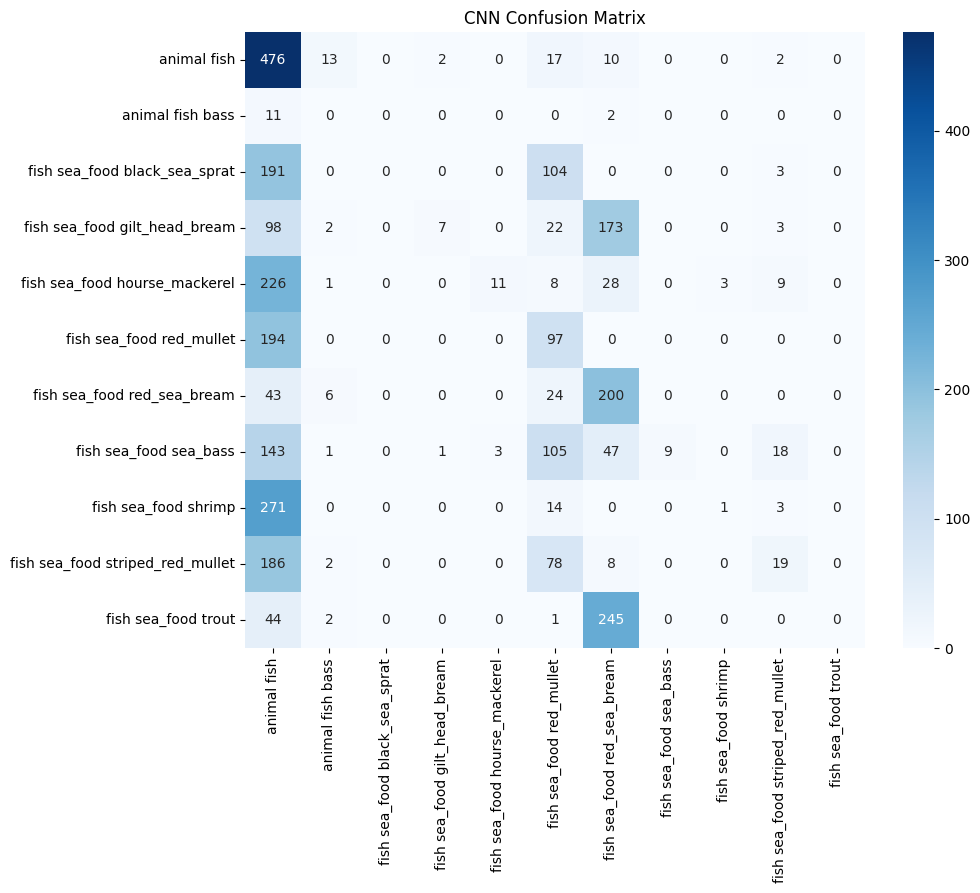

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your saved model
model = tf.keras.models.load_model('fish_species_cnn_final.h5')  # Update with your model path

# Create test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/data/test',  # Update with your test dataset path
    target_size=input_shape[:2],  # Should match training size
    batch_size=batch_size,        # Same as training
    class_mode='categorical',
    shuffle=False                 # Important for correct labels
)

# Evaluate model on test set
print("\nEvaluating model on test set...")
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Get predictions
print("\nGenerating predictions...")
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Evaluate

print("CNN Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras import layers, models, optimizers, callbacks

# Configuration
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
NUM_CLASSES = 11  # Update with your actual number of classes

# Create data generators
def create_generators(data_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        data_dir,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_gen = train_datagen.flow_from_directory(
        data_dir,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_gen = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/test',  # Update with your test path
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = create_generators('/content/drive/MyDrive/data/test')
class_names = list(train_gen.class_indices.keys())

Found 2554 images belonging to 11 classes.
Found 633 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.1398 - loss: 8.6204 - val_accuracy: 0.2986 - val_loss: 3.8748
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2835 - loss: 3.5309 - val_accuracy: 0.5434 - val_loss: 1.4941
Epoch 3/10
20/30 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - accuracy: 0.4472 - loss: 1.6153

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 515ms/step - accuracy: 0.4419 - loss: 1.6169 - val_accuracy: 0.6003 - val_loss: 1.3547
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 855ms/step - accuracy: 0.4805 - loss: 1.5004 - val_accuracy: 0.6730 - val_loss: 1.1034
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 812ms/step - accuracy: 0.5301 - loss: 1.3017 - val_accuracy: 0.7378 - val_loss: 0.9972
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 563ms/step - accuracy: 0.5749 - loss: 1.2518 - val_accuracy: 0.7235 - val_loss: 0.9628
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 816ms/step - accuracy: 0.5681 - loss: 1.1762 - val_accuracy: 0.7314 - val_loss: 0.8838
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 787ms/step - accuracy: 0.6189 - loss: 1.1176 - val_accuracy: 0.8073 - val_loss: 0.7236
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 583ms/step - accuracy: 0.6095 - loss: 1.0653 - val_accuracy: 0.8183 - val_loss: 0.7118
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 819ms/step - accuracy: 0.6331 - loss: 1.0026 - val_accuracy: 0.80

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


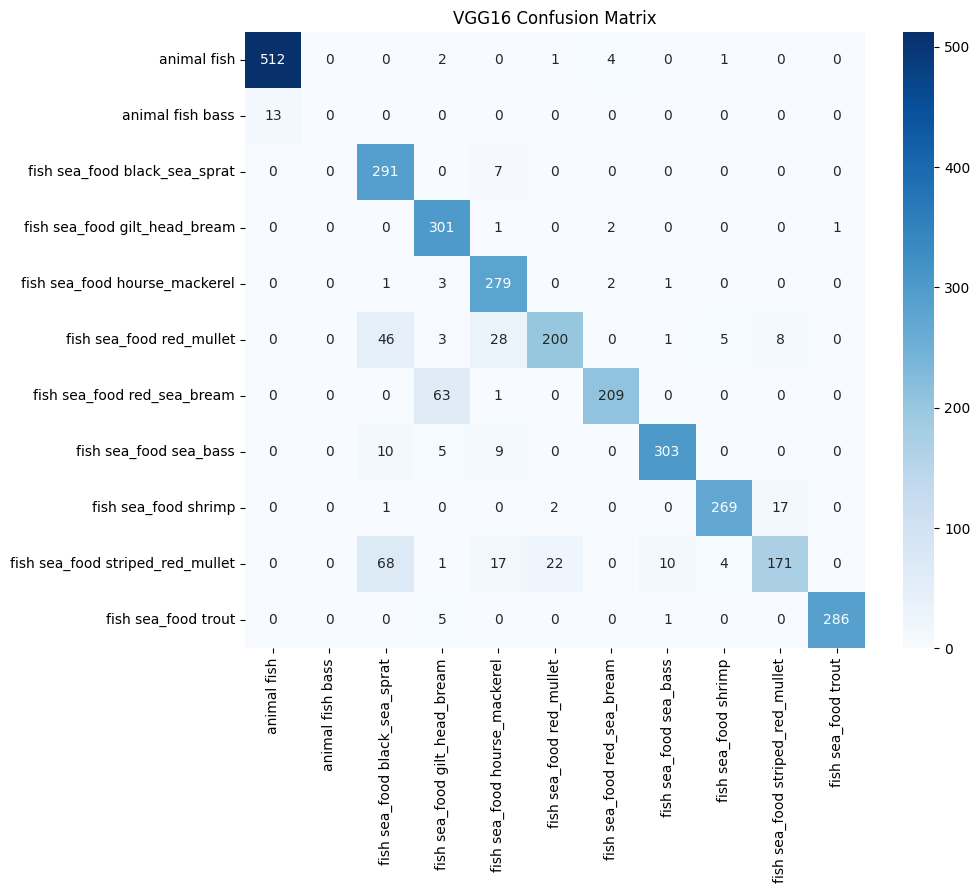

In [ ]:
# Build VGG16 model
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_vgg.trainable = False

vgg_model = models.Sequential([
    base_vgg,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
vgg_history = vgg_model.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=10,
    validation_data=val_gen,
    callbacks=[callbacks.EarlyStopping(patience=3)]
)

# Evaluate
y_pred = vgg_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("VGG16 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('VGG16 Confusion Matrix')
plt.show()

vgg_model.save('vgg16_fish_classifier.h5')

In [ ]:
# Generate plots
plot_training_results(vgg_history, model_name="VGG16")

NameError: name 'vgg_history' is not defined

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.1076 - loss: 2.5802 - val_accuracy: 0.1153 - val_loss: 2.3111
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.1562 - loss: 2.3427 - val_accuracy: 0.1643 - val_loss: 2.2875
Epoch 3/10
20/30 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - accuracy: 0.1574 - loss: 2.3099

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 619ms/step - accuracy: 0.1528 - loss: 2.3125 - val_accuracy: 0.1596 - val_loss: 2.2904
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 868ms/step - accuracy: 0.1673 - loss: 2.2973 - val_accuracy: 0.1880 - val_loss: 2.2877
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 799ms/step - accuracy: 0.1789 - loss: 2.2930 - val_accuracy: 0.1517 - val_loss: 2.2617
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 591ms/step - accuracy: 0.1339 - loss: 2.2843 - val_accuracy: 0.1564 - val_loss: 2.2622
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 895ms/step - accuracy: 0.1580 - loss: 2.2659 - val_accuracy: 0.1501 - val_loss: 2.2445
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 799ms/step - accuracy: 0.1997 - loss: 2.2375 - val_accuracy: 0.1517 - val_loss: 2.2341
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 607ms/step - accuracy: 0.1959 - loss: 2.1963 - val_accuracy: 0.1754 - val_loss: 2.2523
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 812ms/step - accuracy: 0.1589 - loss: 2.2682 - val_accuracy: 0.15

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


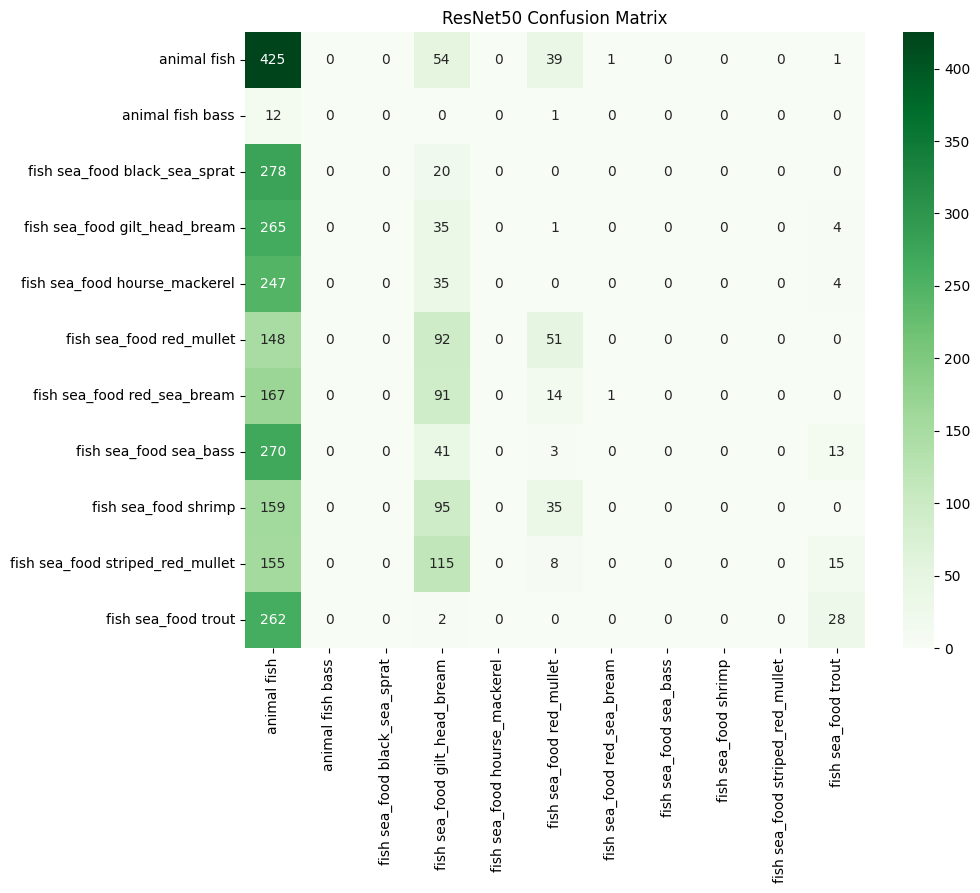

In [ ]:
# Build ResNet50 model
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_resnet.trainable = False

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
resnet_history = resnet_model.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=10,
    validation_data=val_gen,
    callbacks=[callbacks.EarlyStopping(patience=3)]
)

# Evaluate
y_pred = resnet_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print("ResNet50 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 Confusion Matrix')
plt.show()

resnet_model.save('resnet50_fish_classifier.h5')

In [ ]:
# Generate plots
plot_training_results(resnet_history, model_name="ResNet50")

NameError: name 'resnet_history' is not defined

Found 2554 images belonging to 11 classes.
Found 633 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.3057 - loss: 2.1406 - val_accuracy: 0.7725 - val_loss: 0.7631
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.7837 - loss: 0.7163 - val_accuracy: 0.9115 - val_loss: 0.3381
Epoch 3/10
20/30 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8842 - loss: 0.3647

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8842 - loss: 0.3608 - val_accuracy: 0.9352 - val_loss: 0.2634
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9075 - loss: 0.3387 - val_accuracy: 0.9431 - val_loss: 0.2188
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9386 - loss: 0.2435 - val_accuracy: 0.9573 - val_loss: 0.1592
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9287 - loss: 0.2320 - val_accuracy: 0.9589 - val_loss: 0.1370
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.9484 - loss: 0.1746 - val_accuracy: 0.9637 - val_loss: 0.1305
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.9504 - loss: 0.1501 - val_accuracy: 0.9747 - val_loss: 0.1089
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9643 - loss: 0.1370 - val_accuracy: 0.9700 - val_loss: 0.1081
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9596 - loss: 0.1404 - val_accuracy: 0.9731 - val_loss: 0.0842


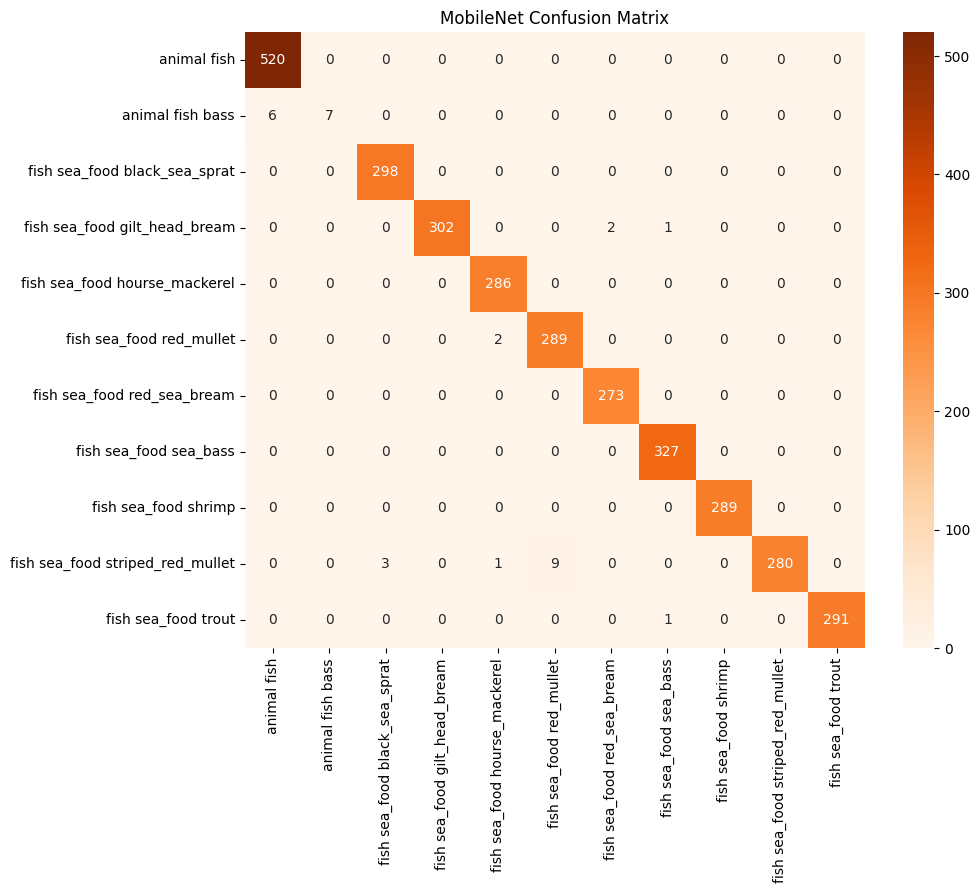

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow as tf

# Configuration
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
NUM_CLASSES = 11  # Update with your actual number of classes

# Create data generators
def create_generators(data_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        data_dir,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_gen = train_datagen.flow_from_directory(
        data_dir,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_gen = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/test',  # Update with your test path
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = create_generators('/content/drive/MyDrive/data/test')
class_names = list(train_gen.class_indices.keys())
y_true = test_gen.classes


# Build MobileNet model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, callbacks

base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_mobilenet.trainable = False

inputs = layers.Input(shape=INPUT_SHAPE)
x = base_mobilenet(inputs, training=False)  # explicitly single input
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

mobilenet_model = models.Model(inputs, outputs)
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
mobilenet_history = mobilenet_model.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=10,
    validation_data=val_gen,
    callbacks=[callbacks.EarlyStopping(patience=3)]
)

# Evaluate
y_pred = mobilenet_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)


print("MobileNet Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title('MobileNet Confusion Matrix')
plt.show()

mobilenet_model.save('mobilenet_fish_classifier.h5')

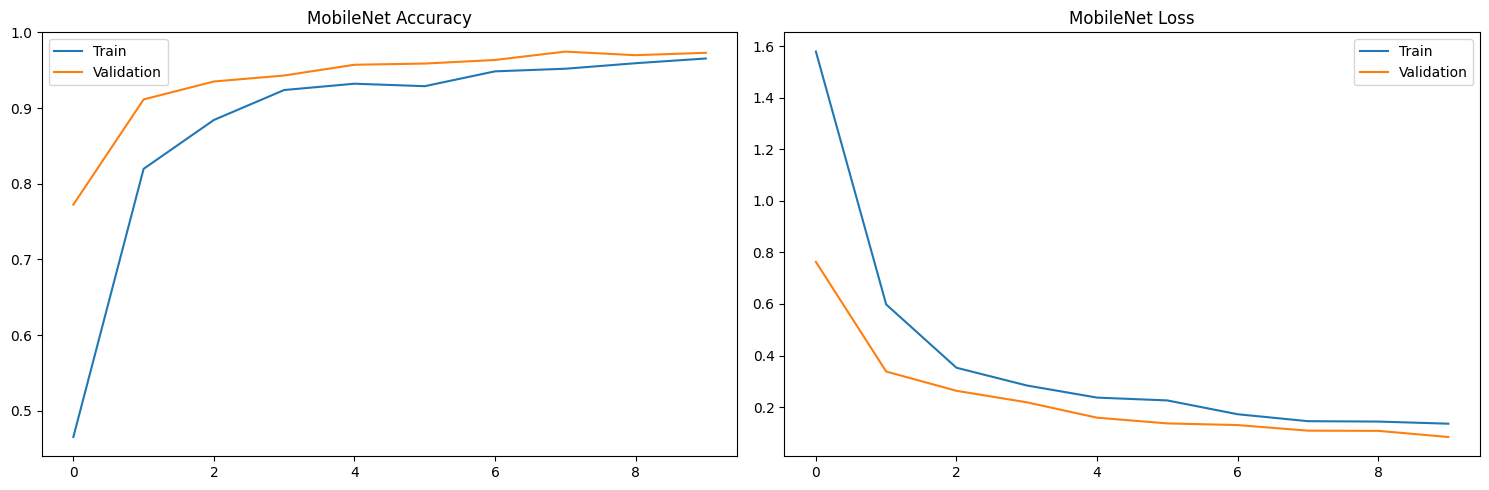

In [ ]:
# Generate plots
plot_training_results(mobilenet_history, model_name="MobileNet")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.1947 - loss: 2.8904 - val_accuracy: 0.7030 - val_loss: 1.0046
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 847ms/step - accuracy: 0.6936 - loss: 0.9768 - val_accuracy: 0.7978 - val_loss: 0.6502
Epoch 3/10
20/30 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.7893 - loss: 0.7053

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 544ms/step - accuracy: 0.7913 - loss: 0.6890 - val_accuracy: 0.8547 - val_loss: 0.4805
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 783ms/step - accuracy: 0.8261 - loss: 0.5488 - val_accuracy: 0.9052 - val_loss: 0.3693
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 785ms/step - accuracy: 0.8428 - loss: 0.5046 - val_accuracy: 0.8878 - val_loss: 0.3349
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 622ms/step - accuracy: 0.8784 - loss: 0.4130 - val_accuracy: 0.8989 - val_loss: 0.3280
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 803ms/step - accuracy: 0.8746 - loss: 0.3812 - val_accuracy: 0.8799 - val_loss: 0.3513
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 872ms/step - accuracy: 0.8676 - loss: 0.3783 - val_accuracy: 0.8863 - val_loss: 0.3369
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 552ms/step - accuracy: 0.8932 - loss: 0.3041 - val_accuracy: 0.9226 - val_loss: 0.2333
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 807ms/step - accuracy: 0.8918 - loss: 0.3209 - val_accuracy: 0.92

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


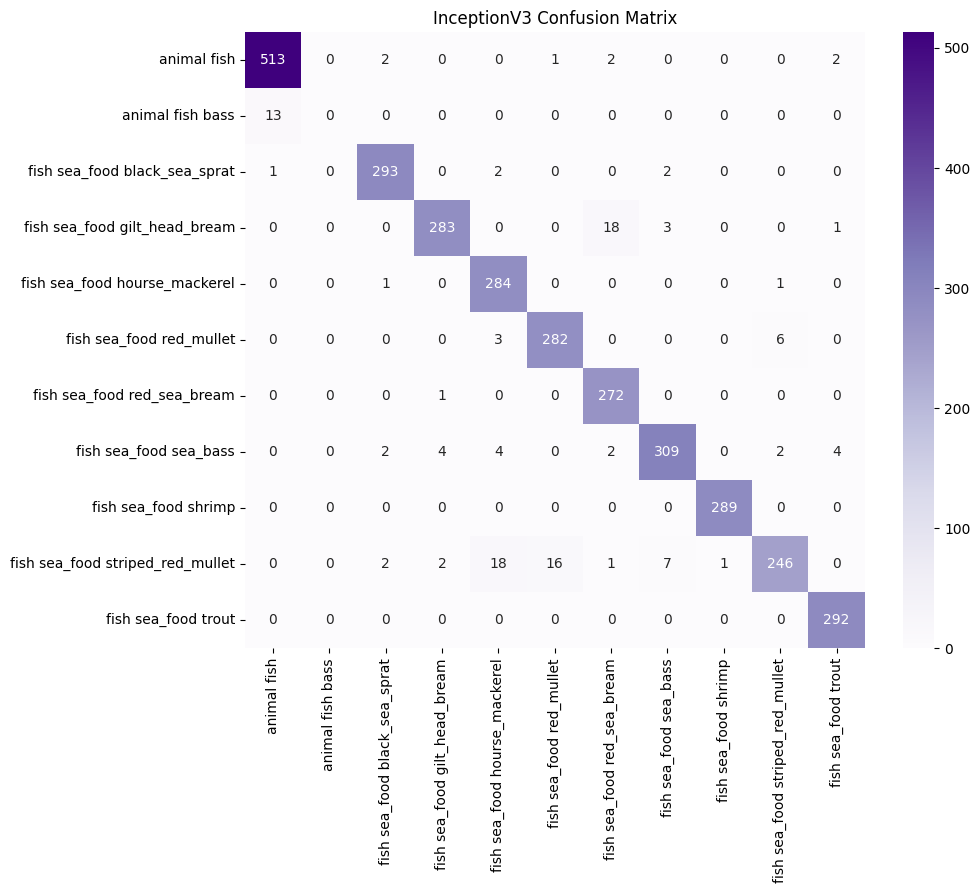

In [ ]:
# Build InceptionV3 model
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_inception.trainable = False

inception_model = models.Sequential([
    base_inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
inception_history = inception_model.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=10,
    validation_data=val_gen,
    callbacks=[callbacks.EarlyStopping(patience=3)]
)

# Evaluate
y_pred = inception_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print("InceptionV3 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('InceptionV3 Confusion Matrix')
plt.show()

inception_model.save('inceptionv3_fish_classifier.h5')

In [ ]:
# Generate plots
plot_training_results(inception_history, model_name="InceptionV3")

NameError: name 'inception_history' is not defined

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.1568 - loss: 2.3761 - val_accuracy: 0.1643 - val_loss: 2.3223
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1434 - loss: 2.3309 - val_accuracy: 0.1643 - val_loss: 2.3116
Epoch 3/10
20/30 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.1394 - loss: 2.3277

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.1362 - loss: 2.3350 - val_accuracy: 0.1643 - val_loss: 2.3273
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 813ms/step - accuracy: 0.1449 - loss: 2.3361 - val_accuracy: 0.1643 - val_loss: 2.3091
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 795ms/step - accuracy: 0.1297 - loss: 2.3494 - val_accuracy: 0.1643 - val_loss: 2.3087
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 584ms/step - accuracy: 0.1555 - loss: 2.3186 - val_accuracy: 0.1643 - val_loss: 2.3058
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 803ms/step - accuracy: 0.1650 - loss: 2.3197 - val_accuracy: 0.1643 - val_loss: 2.2989
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 802ms/step - accuracy: 0.1834 - loss: 2.3024 - val_accuracy: 0.1643 - val_loss: 2.3110
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 553ms/step - accuracy: 0.1431 - loss: 2.3302 - val_accuracy: 0.1643 - val_loss: 2.3032
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 798ms/step - accuracy: 0.1550 - loss: 2.3174 - val_accuracy: 0.16

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


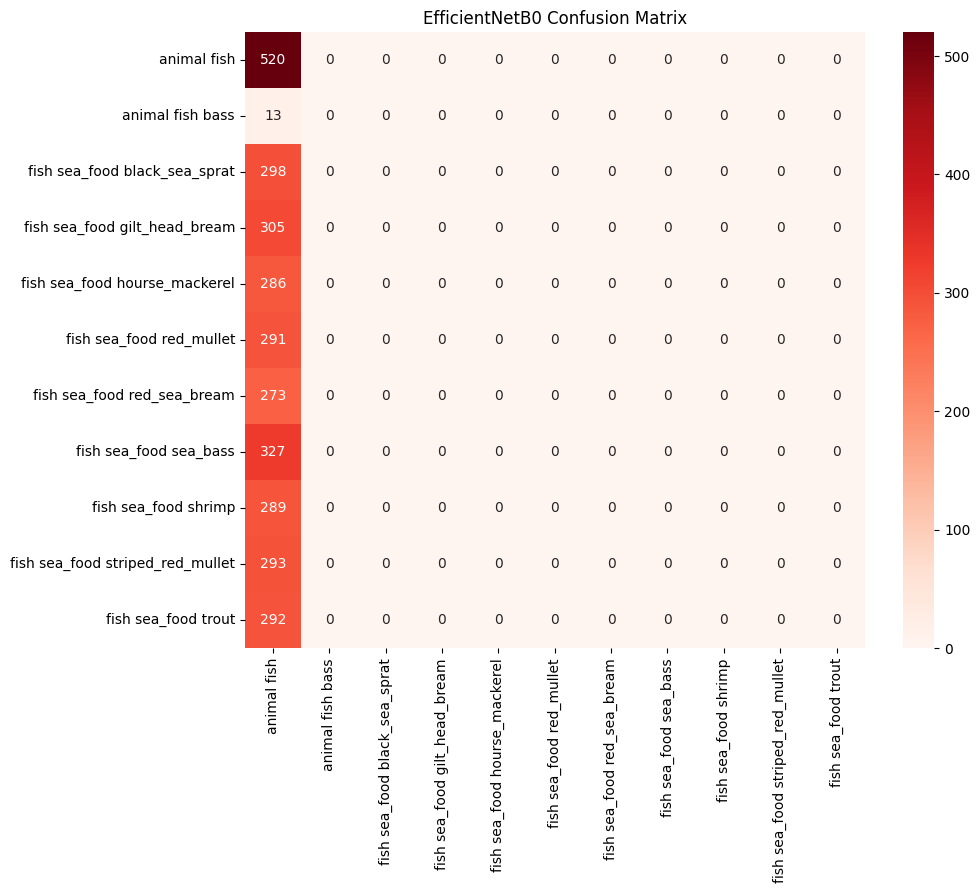

In [ ]:
# Build EfficientNetB0 model
base_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_effnet.trainable = False

effnet_model = models.Sequential([
    base_effnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

effnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
effnet_history = effnet_model.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=10,
    validation_data=val_gen,
    callbacks=[callbacks.EarlyStopping(patience=3)]
)

# Evaluate
y_pred = effnet_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print("EfficientNetB0 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNetB0 Confusion Matrix')
plt.show()

effnet_model.save('efficientnet_fish_classifier.h5')

In [ ]:
# Generate plots
plot_training_results(effnet_history, model_name="EfficientNetB0")

NameError: name 'effnet_history' is not defined

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
import tensorflow as tf

def evaluate_model(model, test_gen):
    # Get predictions
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred_classes, average='weighted', zero_division=0
    )

    # Calculate specificity (requires one-vs-all approach)
    cm = confusion_matrix(y_true, y_pred_classes)
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
        fp = cm[:,i].sum() - cm[i,i]
        specificity.append(tn / (tn + fp))
    specificity = np.mean(specificity)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity
    }

# Load all trained models (update paths if different)
models = {
    'Custom CNN': tf.keras.models.load_model('fish_species_cnn_final.h5'),
    'VGG16': tf.keras.models.load_model('vgg16_fish_classifier.h5'),
    'ResNet50': tf.keras.models.load_model('resnet50_fish_classifier.h5'),
    'MobileNet': tf.keras.models.load_model('mobilenet_fish_classifier.h5'),
    'InceptionV3': tf.keras.models.load_model('inceptionv3_fish_classifier.h5'),
    'EfficientNetB0': tf.keras.models.load_model('efficientnet_fish_classifier.h5')
}

# Evaluate all models
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, test_gen)

# Create comparison dataframe
comparison_df = pd.DataFrame.from_dict(results, orient='index')

# Format for better display
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
comparison_df = comparison_df.round(4) * 100  # Convert to percentages

# Reorder columns (removed Model Size)
comparison_df = comparison_df[[
    'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity'
]]

# Display styled table
styled_df = comparison_df.style \
    .background_gradient(cmap='Blues', subset=['Accuracy']) \
    .background_gradient(cmap='Greens', subset=['F1-Score']) \
    .format("{:.2f}%") \
    .set_caption("Model Performance Comparison") \
    .set_properties(**{
        'text-align': 'center',
        'font-size': '12pt'
    })

display(styled_df)

# Save to CSV
comparison_df.to_csv('model_comparison.csv')

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 186ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 186ms/step


,Accuracy,Precision,Recall,F1-Score,Specificity
MobileNet,98.74%,98.77%,98.74%,98.72%,99.87%
InceptionV3,96.11%,95.79%,96.11%,95.87%,99.61%
VGG16,88.52%,89.38%,88.52%,88.07%,98.85%
Custom CNN,25.73%,37.75%,25.73%,14.96%,92.21%
ResNet50,16.94%,14.77%,16.94%,9.13%,91.15%
EfficientNetB0,16.32%,2.66%,16.32%,4.58%,90.91%


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/mobilenet_fish_classifier.h5")
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,361,489 (12.82 MB)

 Trainable params: 132,619 (518.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 6 (36.00 B)